# Desafío Kopuru 🚀
by *Sergio Tejedor Moreno* - [STM](https://www.tejedormoreno.com)

[Enlace al desafío](https://kopuru.com/challenge/modelo-de-prediccion-de-calidad-en-el-vino-para-aidtec-solutions/?tab=tab-link_datos)

A la hora de analizar los datos deben tenerse en cuenta algunos puntos clave:

1. Cada una de las muestras (registros de las muestras) ha sido tomada de una única botella en las mismas condiciones y momento del proceso (tras el embotellado). Por tanto, todas las muestras están sujetas al mismo proceso, ya que se trata de vinos de año.
2. Es importante analizar en profundidad los datos en busca de posibles errores, que puedan afectar al modelo, y gestionarlos de forma correcta para que no afecten. Se recomienda realizar un EDA previo, que se incluirá en el informe.
3. Es importante realizar un análisis de cuáles son las variables más representativas en la decisión de la asignación de la calidad.
4. Es importante establecer cuáles son los valores máximos y mínimos admisibles para cada parámetro.
5. Aplica transformaciones de variables si fuera necesario.
6. Normaliza la información antes de realizar el modelo y toma decisiones que documentarás en el informe final.

**Objetivo**
1. Desarrollar un modelo de clasificación capaz de predecir con los datos de las muestras del 2024 cuál será la calidad de dichas muestras, tomando como referencia datos entre 2019 y 2023.
2. Desarrollar un informe explicativo donde se desarrollen las conclusiones sobre variables que más influyen en los resultados y el por qué, así como el análisis previo de los datos y sus descriptivos.

# Acerca de este Notebook

- Este notebook parte de los datsasets creados en el notebook anterior y analiza las variables en profundidad, buscando relaciones entre ellas y estudiando sus importancias con respecto a la variable objetivo.
- En este notebook se crearán los datasets definitivos que entrenarán los modelos

# Importaciones

In [ ]:
%pip install icecream

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import random
import matplotlib.pyplot as plt
import joblib
import pickle
from textwrap import dedent
from tqdm.notebook import tqdm_notebook, trange
from icecream import ic

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, cross_val_predict,
                                     cross_validate, StratifiedKFold,
                                     RandomizedSearchCV
                                    )
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (StandardScaler, FunctionTransformer,
                                    LabelEncoder, OneHotEncoder
                                    )
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer
                            )
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (matthews_corrcoef, precision_score,
                            accuracy_score, recall_score,
                            balanced_accuracy_score, f1_score,
                            make_scorer, confusion_matrix, classification_report
                            )

import xgboost as xgb

from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic

from datetime import datetime
import seaborn as sns

# Rutas

In [ ]:
interim_path = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/interim"
    )
)

raw_path = ruta_dataset = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/raw"
    )
)

processed_path = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/processed"
    )
)


df_corregido_file = 'calidad_vino_AT-_train-drop_duplicates-corregir_alcohol-corregir_densidad.csv'
raw_data_file = "calidad_vino_AT-_train.csv"

#Carga de datasets

- Vamos a partir del dataset con los valores de alcohol y densidad corregidos

In [ ]:
df_corregido = pd.read_csv(interim_path / df_corregido_file, index_col=0)

In [ ]:
df_corregido

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,pH,sulfatos,alcohol,color,year,calidad,densidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,3.28,0.73,11.8,tinto,2021,7,0.99720
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,3.34,0.46,11.4,blanco,2021,5,0.99182
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,3.14,0.56,9.7,tinto,2019,5,0.99810
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,3.34,0.52,10.2,blanco,2021,6,0.99521
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,3.05,0.56,11.1,blanco,2023,6,0.99146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,3.19,0.48,9.2,blanco,2021,5,0.99290
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,3.24,0.53,10.3,tinto,2022,5,0.99682
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,3.22,0.60,13.0,tinto,2022,7,1.00040


In [ ]:
df_corregido.describe()

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,pH,sulfatos,alcohol,year,calidad,densidad
count,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000,5027.000000
mean,7.208693,0.340709,0.319216,5.373702,0.056068,30.401333,115.242192,3.219550,0.532009,10.499196,2020.996419,5.812214,0.994669
std,1.297863,0.164362,0.146255,4.707276,0.034810,17.891619,56.591749,0.161547,0.149217,1.182948,1.411674,0.868690,0.002992
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,2.720000,0.220000,8.000000,2019.000000,3.000000,0.987110
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,76.000000,3.110000,0.430000,9.500000,2020.000000,5.000000,0.992370
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,3.210000,0.510000,10.300000,2021.000000,6.000000,0.994800
75%,7.700000,0.410000,0.390000,8.000000,0.066000,41.000000,155.000000,3.320000,0.600000,11.300000,2022.000000,6.000000,0.996900
max,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,4.010000,2.000000,14.900000,2023.000000,9.000000,1.038980


In [ ]:
df_corregido.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre libre    float64
dioxido de azufre total    float64
pH                         float64
sulfatos                   float64
alcohol                    float64
color                       object
year                         int64
calidad                      int64
densidad                   float64
dtype: object

In [ ]:
df_corregido[df_corregido.duplicated()]

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,pH,sulfatos,alcohol,color,year,calidad,densidad
muestra_id,,,,,,,,,,,,,,


# Binarizar variable **color**

- Para estudiar la relación entre las variable, vamos a convertir a numérica la variable **color**. Posteriormente lo agregaremos a una pipeline

In [ ]:
df_color = df_corregido[['color']]
cat_encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
df_color_1hot = cat_encoder.fit_transform(df_color)

In [ ]:
df_color_1hot

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [ ]:
cat_encoder.categories_

[array(['blanco', 'tinto'], dtype=object)]

In [ ]:
cat_encoder.feature_names_in_

array(['color'], dtype=object)

In [ ]:
cat_encoder.get_feature_names_out()

array(['color_tinto'], dtype=object)

In [ ]:
''' preprocessing_color = ColumnTransformer([
    ("color", cat_encoder, make_column_selector(dtype_include=object)),
    ("passthrough", 'passthrough' ,make_column_selector(dtype_include=np.number))
]) '''

' preprocessing_color = ColumnTransformer([\n    ("color", cat_encoder, make_column_selector(dtype_include=object)),\n    ("passthrough", \'passthrough\' ,make_column_selector(dtype_include=np.number))\n]) '

Cambiamos la columna color por la nueva binarizada

In [ ]:
df_corregido.color = df_color_1hot

In [ ]:
df_corregido

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre libre,dioxido de azufre total,pH,sulfatos,alcohol,color,year,calidad,densidad
muestra_id,,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,35.0,67.0,3.28,0.73,11.8,1.0,2021,7,0.99720
1,6.6,0.24,0.28,1.8,0.028,39.0,132.0,3.34,0.46,11.4,0.0,2021,5,0.99182
2,9.4,0.59,0.14,2.0,0.084,25.0,48.0,3.14,0.56,9.7,1.0,2019,5,0.99810
3,6.1,0.32,0.33,10.7,0.036,27.0,98.0,3.34,0.52,10.2,0.0,2021,6,0.99521
4,7.0,0.36,0.35,2.5,0.048,67.0,161.0,3.05,0.56,11.1,0.0,2023,6,0.99146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,21.0,98.0,3.19,0.48,9.2,0.0,2021,5,0.99290
5194,7.1,0.48,0.28,2.8,0.068,6.0,16.0,3.24,0.53,10.3,1.0,2022,5,0.99682
5195,12.0,0.37,0.76,4.2,0.066,7.0,38.0,3.22,0.60,13.0,1.0,2022,7,1.00040


# Visualización de las variables

## Boxplots

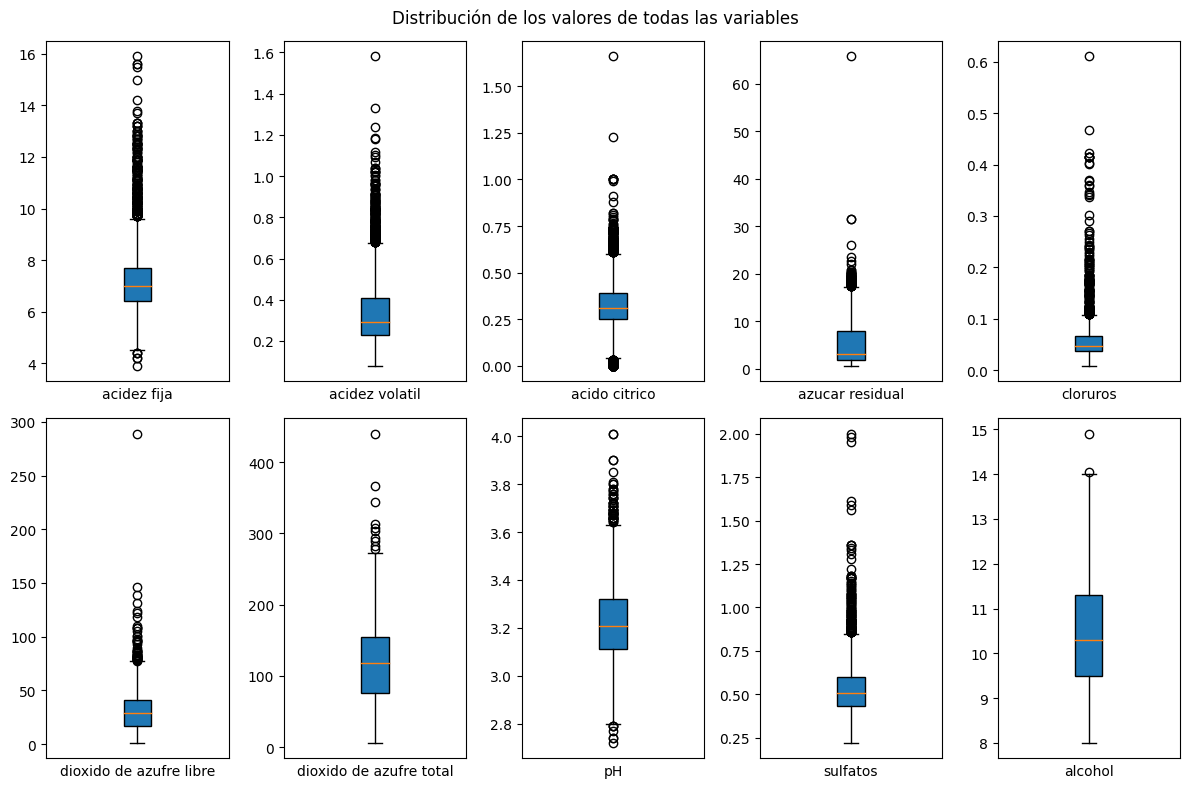

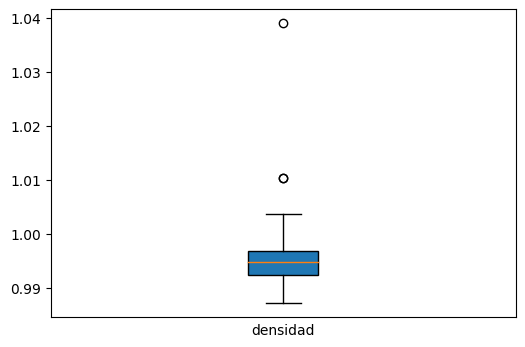

In [ ]:
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.suptitle('Distribución de los valores de todas las variables')
float_cols = df_corregido.select_dtypes('float64').columns

idx = 0
for i in range(n_rows):
    for j in range(n_cols):
        col = float_cols[idx]
        ax[i, j].boxplot(df_corregido[col], patch_artist=True, vert=True);
        ax[i, j].set_xlabel(col)
        ax[i, j].set_xticks([])
        idx += 1
plt.tight_layout()

# Ploteamos la última varaible
plt.figure(figsize=(6, 4))
plt.boxplot(df_corregido[float_cols[-1]], patch_artist=True, vert=True)
plt.xlabel(float_cols[-1])
plt.xticks([])
plt.show()

## Distribución de los valores de las variables

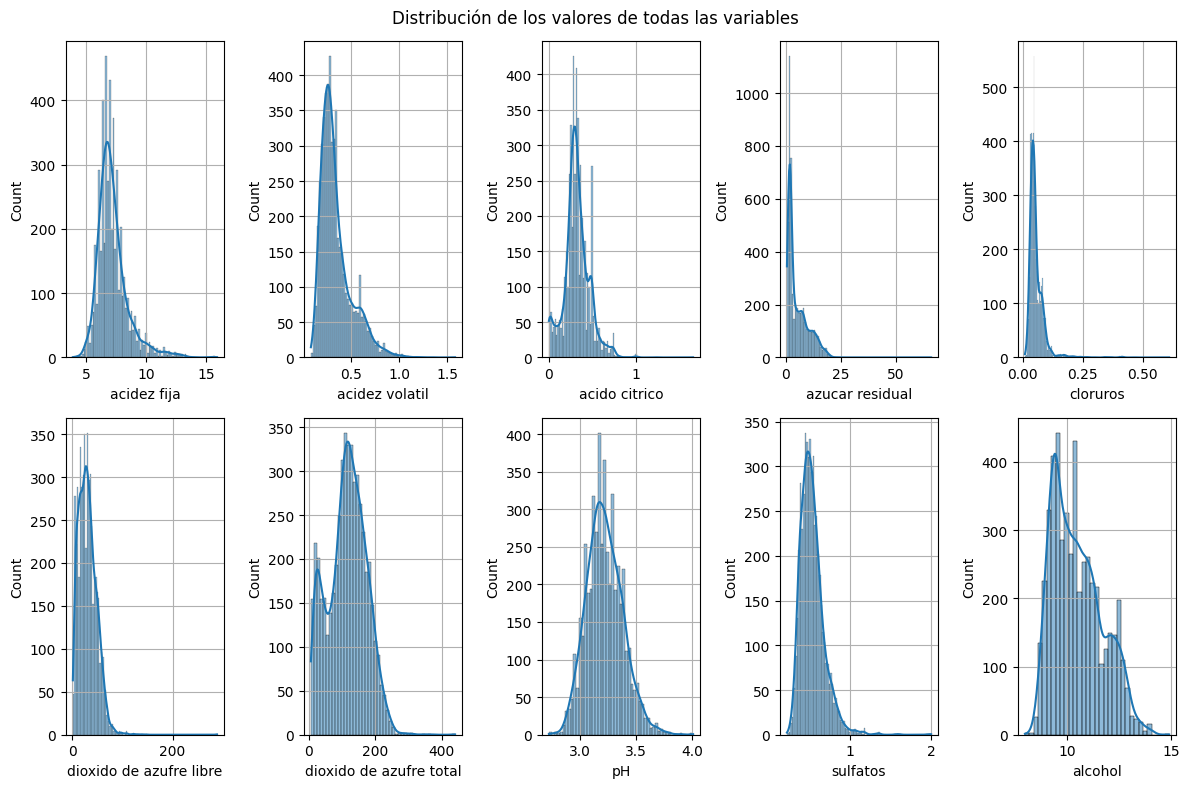

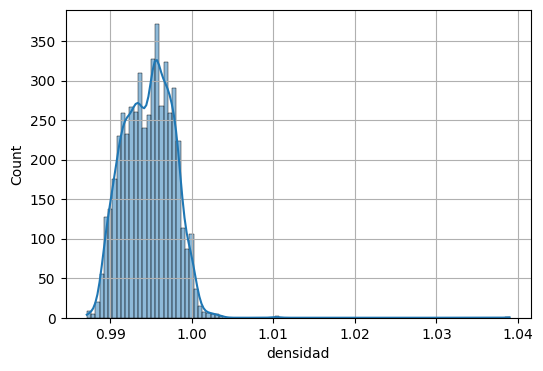

In [ ]:
n_rows = 2
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.suptitle('Distribución de los valores de todas las variables')
float_cols = df_corregido.select_dtypes('float64').columns

idx = 0
for i in range(n_rows):
    for j in range(n_cols):
        col = float_cols[idx]
        ax[i, j].grid(True)
        sns.histplot(df_corregido[col], ax=ax[i, j], kde=True);
        ax[i, j].set_xlabel(col)
        idx += 1
plt.tight_layout()

# Ploteamos la última varaible
plt.figure(figsize=(6, 4))
sns.histplot(df_corregido[float_cols[-1]], kde=True)
plt.xlabel(float_cols[-1])
plt.grid(True)
plt.show()

- Vemos que si bien los outliers no están muy alejados, sí podría ser interesante probar con ellos eliminados y ver si el modelo generaliza mejor. utilizarmos **IsolationForest** para quitar los outliers

# Relación entre variables

## Correlaciones

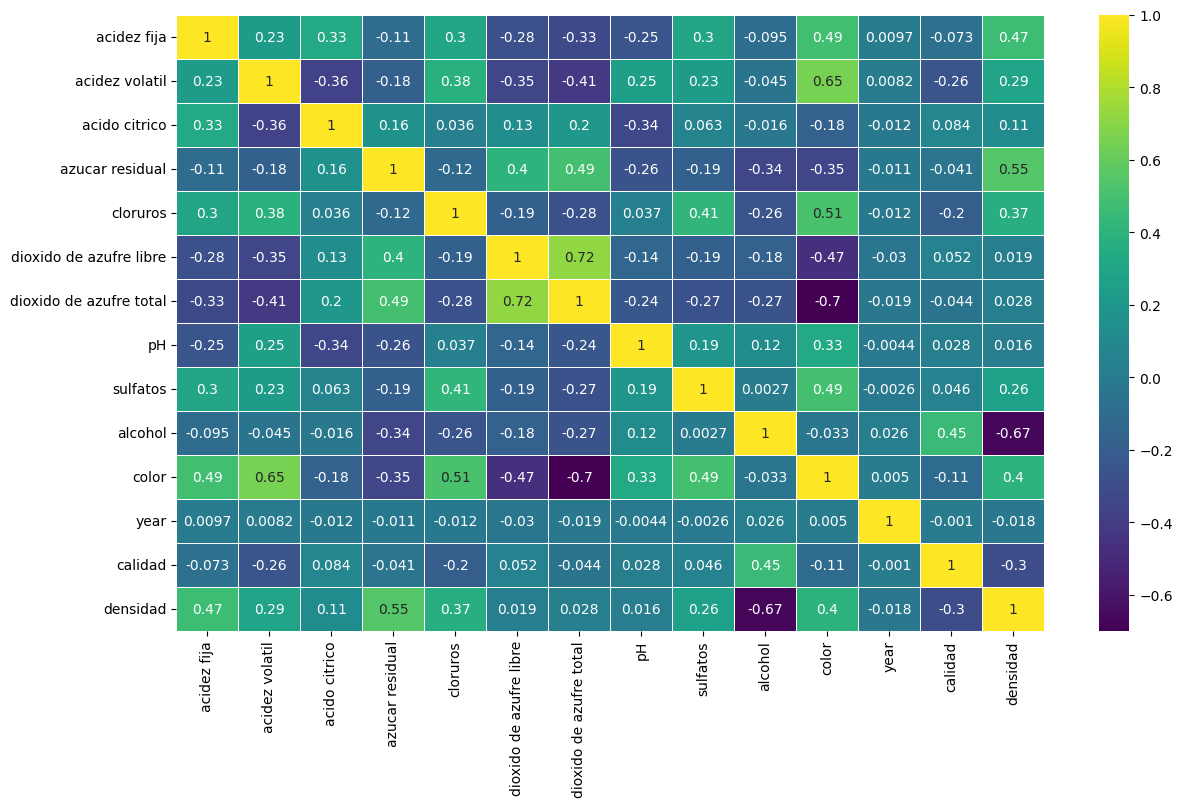

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_corregido.corr(numeric_only=True), annot=True, linewidth=.5, cmap='viridis')
plt.show()

- Comprobamos a simple vista varios hechos:
1. El **alcohol** es la variable que mejor correlaciona con nuestra variable objetivo seguida de la densidad (correlación negativa)
2. La relación más fuerte se da entre **dioxido de azufre libre** y **dioxido de azufre total**. Esto es lógico ya que están relacionadas. Para no incurrir en problemas de multicolinealidad, crearemos una nueva variable relacionando ambas que sea la relación de dióxido de azufre libre en relación al total
3. Hay una correlación fuerte inversa entre el **dioxido de azufre total** y el **color del vino**: Esto tiene sentido desde una perspectiva enológica, ya que los vinos blancos generalmente requieren niveles más altos de SO2 total comparados con los vinos tintos. El SO2 actúa como un conservante y antioxidante, y los vinos blancos, que son más susceptibles a la oxidación debido a la menor cantidad de taninos (que tienen propiedades antioxidantes), suelen necesitar una mayor protección.

## Creación variable ratio So2_l / So2_tot

In [ ]:
def column_ratio(X):
    return X[0, :] / X[1, :]

def ratio_name(function_transformer, feature_names_in):
    return ["dioxido de azufre libre / dioxido de azufre total"]  # feature names out

ratio_transformer = FunctionTransformer(column_ratio)

In [ ]:
so2_ratio = ratio_transformer.transform(np.array([df_corregido['dioxido de azufre libre'], df_corregido['dioxido de azufre total']]))

In [ ]:
df_corregido['ratio so2_l / s02_tot'] = so2_ratio

In [ ]:
df_corregido = df_corregido.drop(columns=['dioxido de azufre libre'])

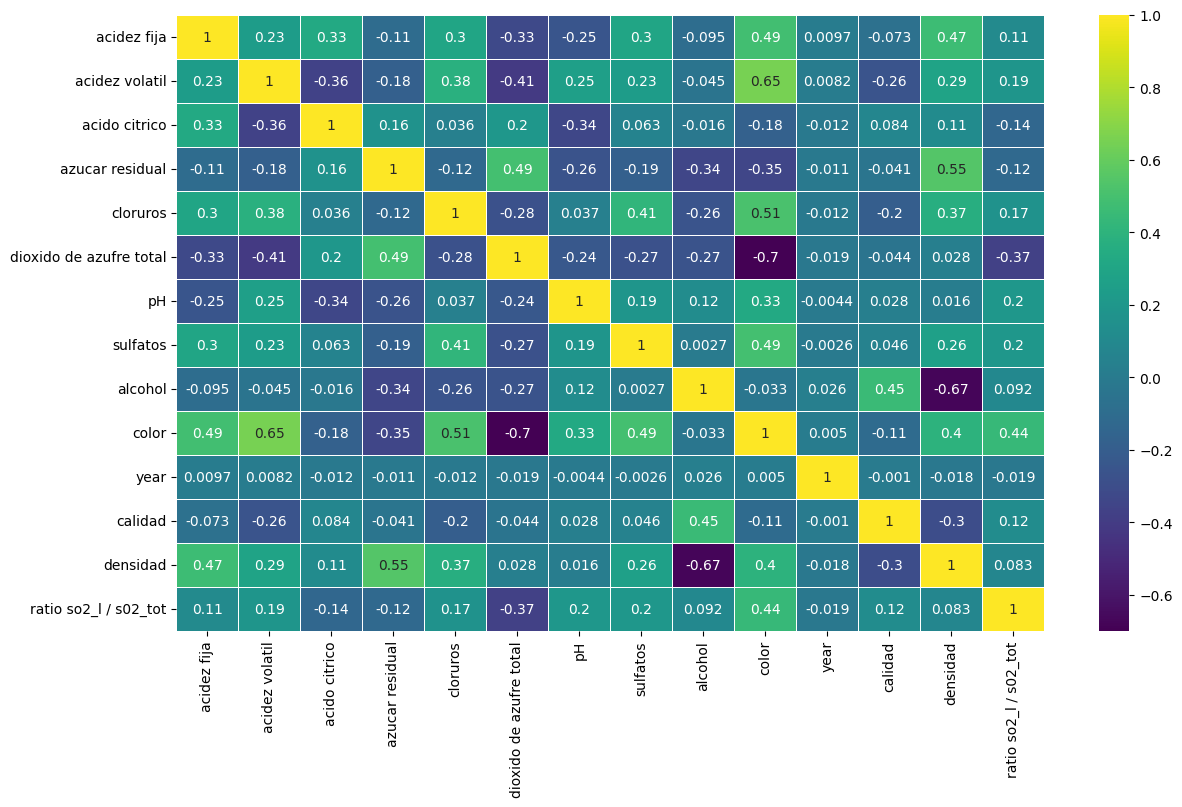

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_corregido.corr(numeric_only=True), annot=True, linewidth=.5, cmap='viridis')
plt.show()

## Cruces entre variables

- Definimos una función para graficar la dispersión entre dos variables y visualizando la calidad en una tercera dimensión

In [ ]:
# Definimos la paleta de colores utilizando un mapa de colores que va de rojo a verde pasando por amarillo
# Utilizamos 'RdYlGn' que es el mapa de colores de rojo a verde pasando por amarillo
palette = sns.color_palette("RdYlGn", 7)
# Establecemos la paleta de colores
sns.set_palette(palette)
# Mapeamos los valores de la columna 'calidad' a colores para la visualización
target_colors = {
    cal: pal
    for cal, pal in zip(
        df_corregido.calidad.sort_values().unique(),
        sns.color_palette().as_hex())}
colors = df_corregido.calidad.map(target_colors)
# Definimos una transparencia para todos los plots
alpha= 0.6

def plot_2_variables(df: pd.DataFrame, var_x: str, var_y: str) -> None:
    """Muestra un gráfico de dispersión entre 2 variables y resalta
    en colores las valoraciones"""
    plt.figure(figsize=(12, 6))
    plt.scatter(df[var_x], df[var_y], c=colors, alpha=alpha);

    plt.title(f'Relación entre {var_x} y {var_y}');
    plt.xlabel(var_x);
    plt.ylabel(var_y);

    plt.grid(linestyle='--', linewidth=0.8)

    legend_patches = [
        mpatches.Patch(color=color, label=target)
        for target, color in target_colors.items()]
    plt.legend(handles=legend_patches, title='Calidad', loc='best')
    plt.show()

### Azucar residual vs densidad

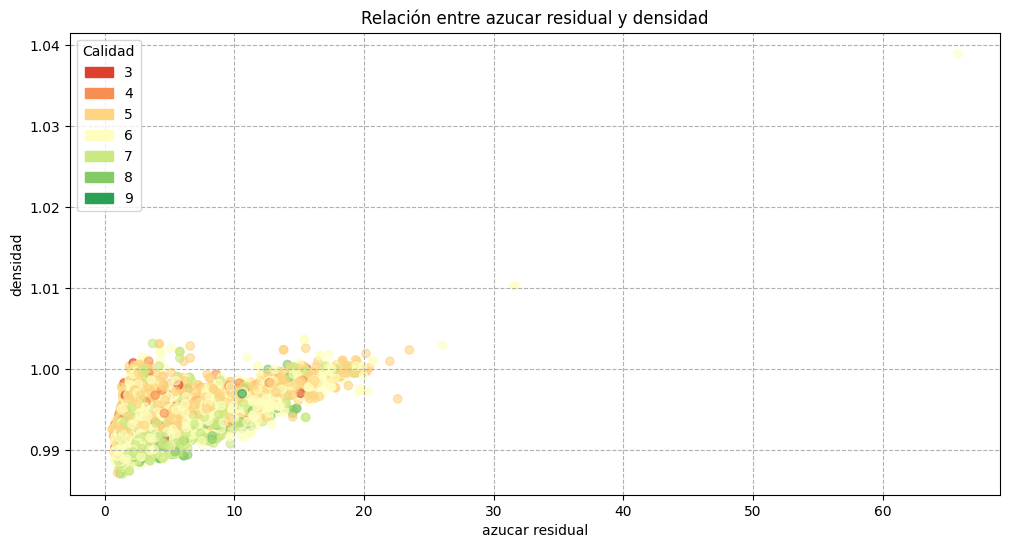

In [ ]:
var_x = 'azucar residual'
var_y = 'densidad'

plot_2_variables(df_corregido, var_x, var_y)

### Densidad vs alcohol

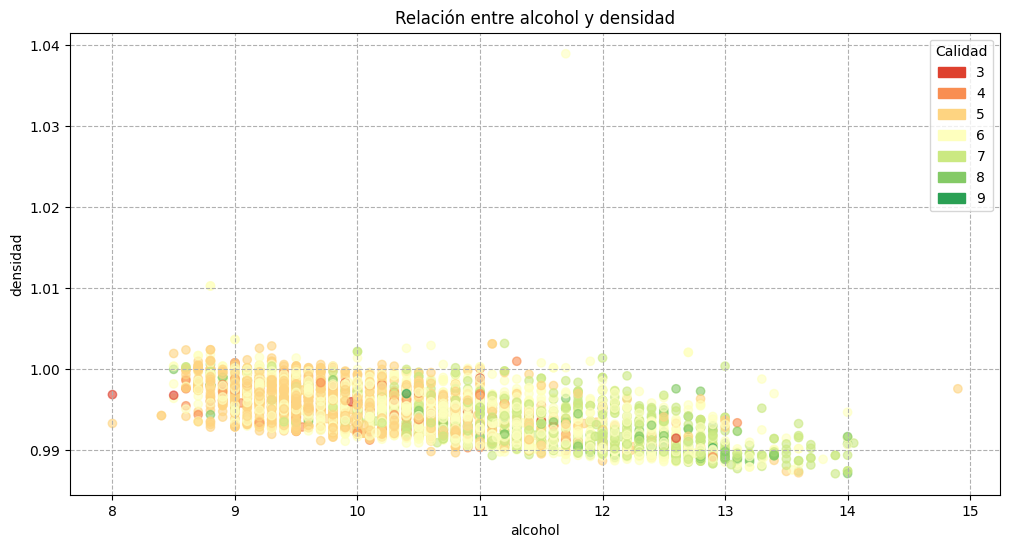

In [ ]:
var_x = 'alcohol'
var_y = 'densidad'

plot_2_variables(df_corregido, var_x, var_y)

- A mayor alcohol, menor densidad y más muestras con mejor calidad

### Acidez fija vs ph

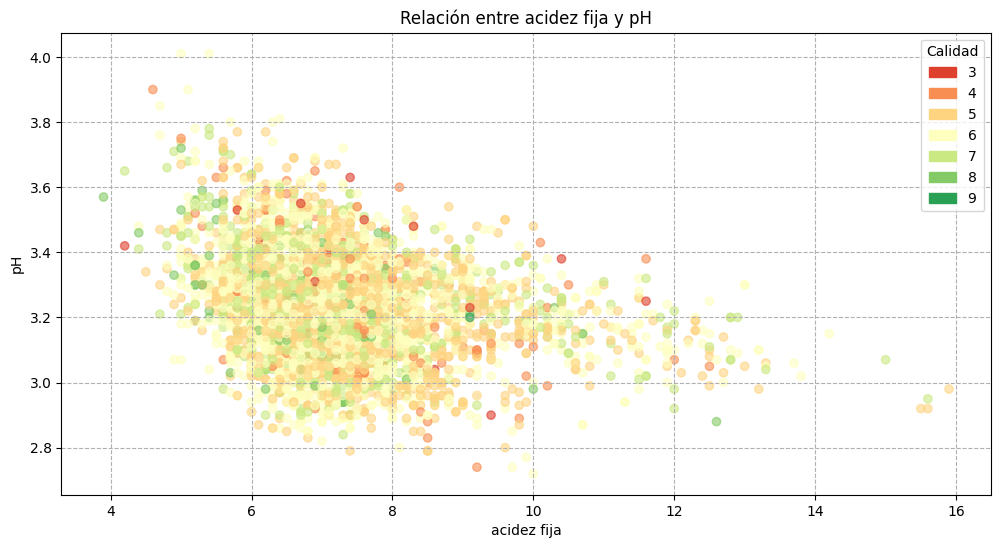

In [ ]:
var_x = 'acidez fija'
var_y = 'pH'

plot_2_variables(df_corregido, var_x, var_y)

### Ácido cítrico vs pH

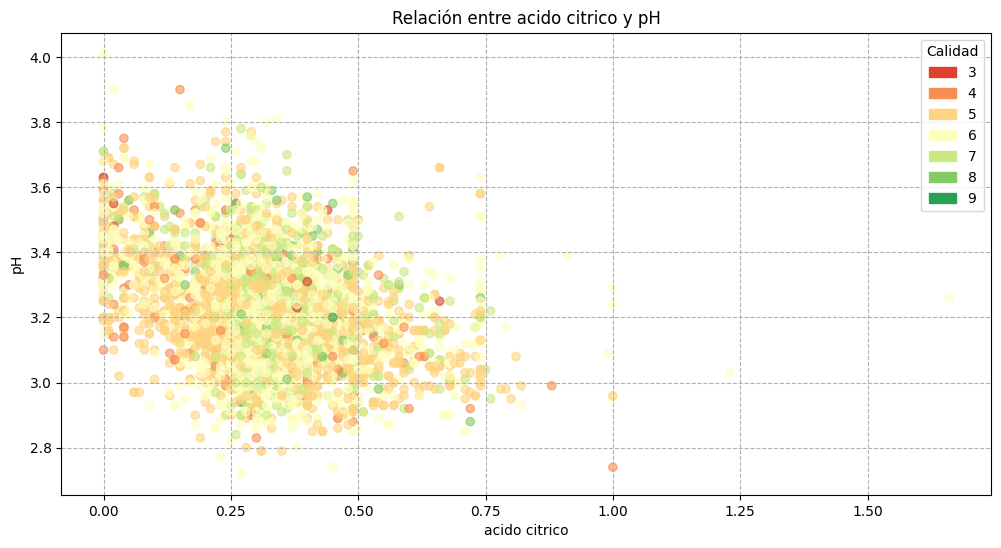

In [ ]:
var_x = 'acido citrico'
var_y = 'pH'

plot_2_variables(df_corregido, var_x, var_y)

### Acidez volátil vs pH

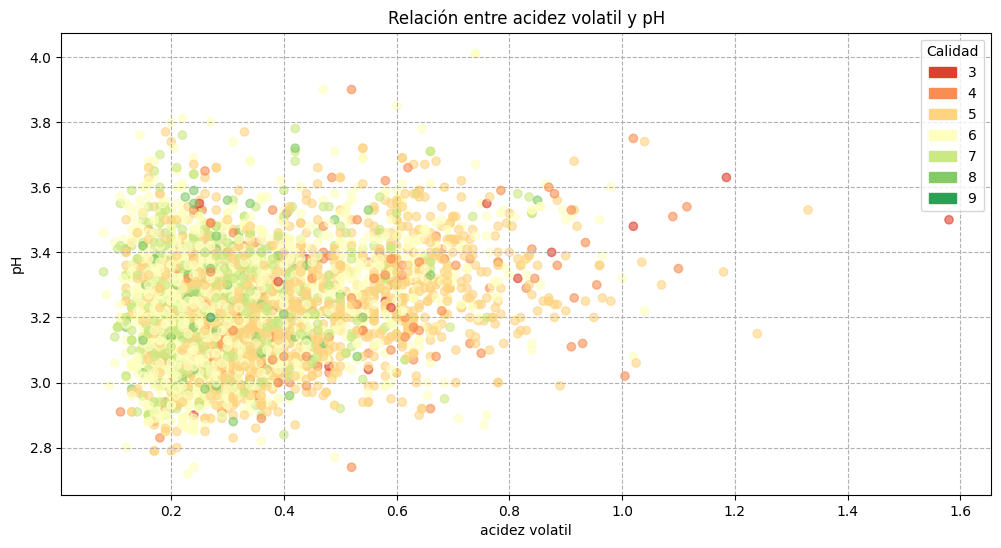

In [ ]:
var_x = 'acidez volatil'
var_y = 'pH'

plot_2_variables(df_corregido, var_x, var_y)

- Parece que las muestras con mejor calidad se concentran en valores bajos de acidez

## Mutual information

- Creamos una función para plotear las informaciones mutuas entre las variables y la variable objetivo

In [ ]:
def make_mi_scores(
    X:pd.DataFrame,
    y:pd.Series,
    discrete_features="auto"
    ) -> pd.Series:
    """Crea los MI entre las variables de X e y"""
    mi_scores = mutual_info_classif(
        X,
        y,
        discrete_features=discrete_features,
        random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores:pd.Series, ax:plt.Axes) -> None:
    """Plotea los Mi scores en un histograma"""
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    ax.barh(width, scores, color='#6dcd59')
    ax.set_yticks(range(len(scores)), labels=scores.index);
    ax.set_title("Mutual Information Scores")

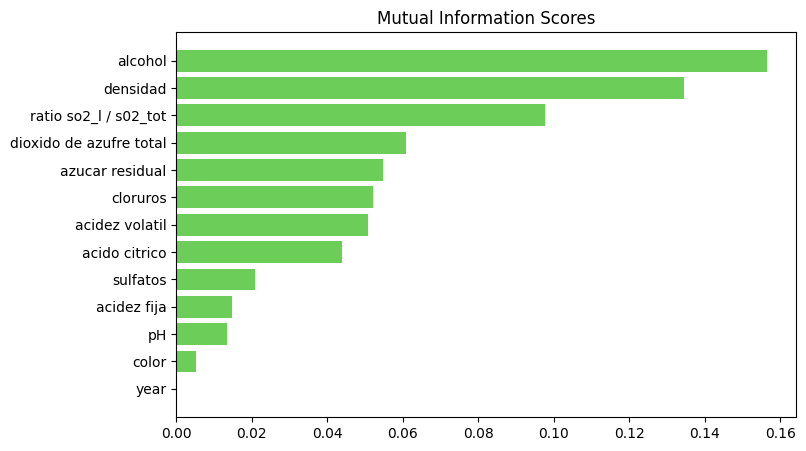

In [ ]:
X = df_corregido.copy()
y = X.pop('calidad')

mi_scores = make_mi_scores(X, y)
mi_scores

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plot_mi_scores(mi_scores, ax1)

- Las Mutual Informations concluyen que las variables más importantes para explicar la calidad del vino son:
1. el Alcohol
2. la densidad
3. el ratio So2_l / So2_tot

- Llama la atención como el año no aporta ninguna información para explicar la calidad

- Vamos a hacer una segunda verificación utilizando un Random Forest y sus **feature_importances_**

## Feature Importances con RF

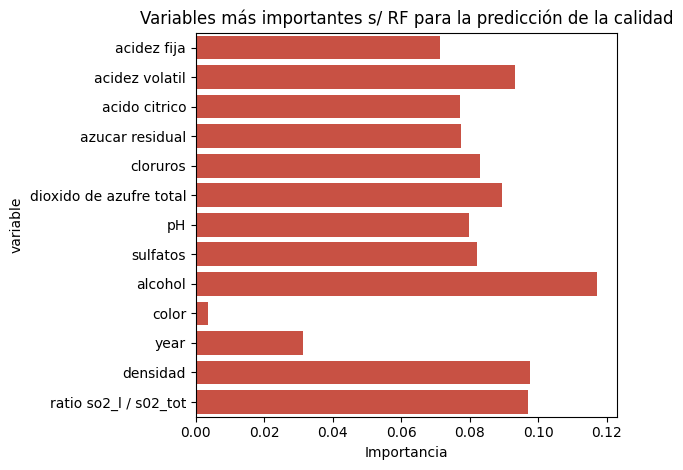

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)
fig, ax = plt.subplots()
ax = sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)
plt.title('Variables más importantes s/ RF para la predicción de la calidad')
plt.xlabel('Importancia')
plt.ylabel('variable')
plt.tight_layout()
plt.show()

- El Random Forest coincide en importancia con la MI sin embargo en relación al año parece que éste otorga algo más de importancia al año que la MI

- Podríamos plantearnos eliminar las variables menos representativas

# Eliminación Variable **year**

- Vamos a suprimir la variable **year** y estudiar el dataset ya que no aporta ninguna información a la calidad del vino

In [ ]:
df_corregido_sin_year = df_corregido.drop(columns=['year'])

In [ ]:
df_corregido_sin_year

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre total,pH,sulfatos,alcohol,color,calidad,densidad,ratio so2_l / s02_tot
muestra_id,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,67.0,3.28,0.73,11.8,1.0,7,0.99720,0.522388
1,6.6,0.24,0.28,1.8,0.028,132.0,3.34,0.46,11.4,0.0,5,0.99182,0.295455
2,9.4,0.59,0.14,2.0,0.084,48.0,3.14,0.56,9.7,1.0,5,0.99810,0.520833
3,6.1,0.32,0.33,10.7,0.036,98.0,3.34,0.52,10.2,0.0,6,0.99521,0.275510
4,7.0,0.36,0.35,2.5,0.048,161.0,3.05,0.56,11.1,0.0,6,0.99146,0.416149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,5.8,0.15,0.49,1.1,0.048,98.0,3.19,0.48,9.2,0.0,5,0.99290,0.214286
5194,7.1,0.48,0.28,2.8,0.068,16.0,3.24,0.53,10.3,1.0,5,0.99682,0.375000
5195,12.0,0.37,0.76,4.2,0.066,38.0,3.22,0.60,13.0,1.0,7,1.00040,0.184211


- Comprobamos si hay valores duplicados ahora que hemos eliminado la variable año

In [ ]:
df_corregido_sin_year[df_corregido_sin_year.duplicated()]

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre total,pH,sulfatos,alcohol,color,calidad,densidad,ratio so2_l / s02_tot
muestra_id,,,,,,,,,,,,,
328,6.5,0.22,0.19,1.1,0.064,191.0,3.05,0.50,9.5,0.0,6,0.99297,0.188482
331,7.4,0.33,0.26,15.6,0.049,210.0,3.06,0.68,9.5,0.0,5,0.99907,0.319048
332,7.3,0.22,0.41,15.4,0.050,191.0,3.32,0.59,8.9,0.0,6,1.00000,0.287958
386,7.4,0.31,0.26,8.6,0.048,206.0,3.26,0.36,9.1,0.0,5,0.99640,0.228155
393,8.3,0.16,0.37,7.9,0.025,107.0,2.93,0.37,11.9,0.0,6,0.99306,0.355140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172,6.9,0.30,0.25,3.3,0.041,124.0,3.18,0.50,9.3,0.0,6,0.99428,0.209677
5175,5.9,0.29,0.16,7.9,0.044,197.0,3.21,0.36,9.4,0.0,5,0.99512,0.243655
5186,7.1,0.33,0.64,13.2,0.056,105.0,3.05,0.39,9.2,0.0,5,0.99720,0.114286


Sorprendentemente hay 610 registros duplicados. Es decir, que hay 610 registros que se han repetido en diferentes años. Hay 12 muestreos de laboratorio que se han repetido exactamente en diferentes años con una precisión de 4 decimales en algunos casos.
- Este hecho es altamente improbable lo cual lleva a pensar que los valores han sido duplicados artificialmente y asignados a años distintos

- Eliminamos estos registros duplicados

In [ ]:
df_corregido_sin_year_drop_duplicated = df_corregido_sin_year.drop_duplicates()

In [ ]:
df_corregido_sin_year_drop_duplicated

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre total,pH,sulfatos,alcohol,color,calidad,densidad,ratio so2_l / s02_tot
muestra_id,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,67.0,3.28,0.73,11.8,1.0,7,0.99720,0.522388
1,6.6,0.24,0.28,1.8,0.028,132.0,3.34,0.46,11.4,0.0,5,0.99182,0.295455
2,9.4,0.59,0.14,2.0,0.084,48.0,3.14,0.56,9.7,1.0,5,0.99810,0.520833
3,6.1,0.32,0.33,10.7,0.036,98.0,3.34,0.52,10.2,0.0,6,0.99521,0.275510
4,7.0,0.36,0.35,2.5,0.048,161.0,3.05,0.56,11.1,0.0,6,0.99146,0.416149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,7.0,0.34,0.30,1.8,0.045,142.0,2.99,0.45,10.8,0.0,6,0.99140,0.309859
5193,5.8,0.15,0.49,1.1,0.048,98.0,3.19,0.48,9.2,0.0,5,0.99290,0.214286
5194,7.1,0.48,0.28,2.8,0.068,16.0,3.24,0.53,10.3,1.0,5,0.99682,0.375000


Guardamos este dataset

In [ ]:
df_name = "calidad_vino_AT-_train-drop_duplicates-corregir_alcohol-corregir_densidad-color_binarizado-ratio_so2-drop_year-drop_duplicates.csv"
df_corregido_sin_year_drop_duplicated.to_csv(interim_path / df_name)

# Outliers

- Vamos a eliminar algún outlier utilizando la clase **IsolationForest**

In [ ]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_corregido_sin_year_drop_duplicated)

In [ ]:
outlier_pred, len(outlier_pred)

(array([ 1,  1,  1, ...,  1, -1,  1]), 4417)

In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers = df_corregido_sin_year_drop_duplicated.iloc[outlier_pred == 1]

In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre total,pH,sulfatos,alcohol,color,calidad,densidad,ratio so2_l / s02_tot
muestra_id,,,,,,,,,,,,,
0,9.5,0.56,0.33,2.4,0.089,67.0,3.28,0.73,11.8,1.0,7,0.99720,0.522388
1,6.6,0.24,0.28,1.8,0.028,132.0,3.34,0.46,11.4,0.0,5,0.99182,0.295455
2,9.4,0.59,0.14,2.0,0.084,48.0,3.14,0.56,9.7,1.0,5,0.99810,0.520833
3,6.1,0.32,0.33,10.7,0.036,98.0,3.34,0.52,10.2,0.0,6,0.99521,0.275510
4,7.0,0.36,0.35,2.5,0.048,161.0,3.05,0.56,11.1,0.0,6,0.99146,0.416149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,7.2,0.53,0.14,2.1,0.064,29.0,3.35,0.61,12.1,1.0,6,0.99323,0.517241
5191,7.0,0.34,0.30,1.8,0.045,142.0,2.99,0.45,10.8,0.0,6,0.99140,0.309859
5193,5.8,0.15,0.49,1.1,0.048,98.0,3.19,0.48,9.2,0.0,5,0.99290,0.214286


In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers.columns

Index(['acidez fija', 'acidez volatil', 'acido citrico', 'azucar residual',
       'cloruros', 'dioxido de azufre total', 'pH', 'sulfatos', 'alcohol',
       'color', 'calidad', 'densidad', 'ratio so2_l / s02_tot'],
      dtype='object')

# Estandarización

In [ ]:
scaler = StandardScaler()
array_prep = scaler.fit_transform(df_corregido_sin_year_drop_duplicated_sin_outliers[
    ['acidez fija', 'acidez volatil', 'acido citrico', 'azucar residual',
     'cloruros', 'dioxido de azufre total', 'pH', 'sulfatos', 'alcohol',
     'densidad', 'ratio so2_l / s02_tot']
])

In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers_std = pd.concat([
    pd.DataFrame(
    array_prep,
    columns=scaler.get_feature_names_out(),
    index=df_corregido_sin_year_drop_duplicated_sin_outliers.index
),
    df_corregido_sin_year_drop_duplicated_sin_outliers['color'],
    df_corregido_sin_year_drop_duplicated_sin_outliers['calidad']
],
                                                                   axis=1)

In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers_std = df_corregido_sin_year_drop_duplicated_sin_outliers_std.reset_index(drop=True)
df_corregido_sin_year_drop_duplicated_sin_outliers_std

,acidez fija,acidez volatil,acido citrico,azucar residual,cloruros,dioxido de azufre total,pH,sulfatos,alcohol,densidad,ratio so2_l / s02_tot,color,calidad
0,2.364667,1.624852,0.105146,-0.630860,1.587422,-0.989479,0.394233,1.738034,1.121380,1.051945,2.186663,1.0,7
1,-0.446891,-0.564399,-0.279214,-0.767174,-1.012555,0.238310,0.787325,-0.449722,0.772019,-0.903252,0.174129,0.0,5
2,2.267717,1.830094,-1.355422,-0.721736,1.374310,-1.348371,-0.522983,0.360558,-0.712767,1.379022,2.172875,1.0,5
3,-0.931642,-0.017086,0.105146,1.254819,-0.671575,-0.403918,0.787325,0.036446,-0.276065,0.328740,-0.002745,0.0,6
4,-0.059090,0.256570,0.258890,-0.608141,-0.160104,0.786092,-1.112621,0.360558,0.509998,-1.034083,1.244495,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959,0.134811,1.419610,-1.355422,-0.699017,0.521858,-1.707263,0.852840,0.765698,1.383401,-0.390830,2.141020,1.0,6
3960,-0.059090,0.119742,-0.125470,-0.767174,-0.287971,0.427200,-1.505713,-0.530750,0.247977,-1.055888,0.301875,0.0,6
3961,-1.222493,-1.180126,1.335099,-0.926207,-0.160104,-0.403918,-0.195406,-0.287666,-1.149468,-0.510759,-0.545708,0.0,5
3962,0.037861,1.077539,-0.279214,-0.539984,0.692348,-1.952820,0.132171,0.117474,-0.188725,0.913846,0.879569,1.0,5


In [ ]:
df_corregido_sin_year_drop_duplicated_sin_outliers_std['calidad'].value_counts(normalize=True).sort_index()

calidad
3    0.001514
4    0.030777
5    0.326942
6    0.460646
7    0.153633
8    0.025227
9    0.001261
Name: proportion, dtype: float64

# Pipelines

Las operaciones que incluiremos en las pipelines son las siguientes:

1. drop duplicates
2. corregir alcohol
3. corregir densidad
4. Binarizar color
5. Creación variable So2_l / So2_tot
5. Supresión de outliers ?
6. Estandarización

- Vamos a crear varios tipos de pipelines con diferentes procesamientos del dataset para evaluar cual tiene mejor comportamiento con diferentes modelos de ML

- Definimos funciones de procesamiento y creamos las pipelines

## Transformers y funciones auxiliares

In [ ]:
class DropDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        ic(X.shape)
        self.idx_duplicados_ = X.loc[X.duplicated(), :].index
        #X_transformado = X.drop_duplicates().reset_index(drop=True)
        X_transformado = X.drop(index=self.idx_duplicados_).reset_index(drop=True)
        return X_transformado

    def get_feature_names_out(self, input_features=None):
        return self.columns_names

class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: np.ndarray, y=None) -> 'Self':
        self.n_features_in_ = X.shape[1]

        # Entrenamos el isolation_forest
        isolation_forest = IsolationForest(random_state=42)
        self.outlier_pred = isolation_forest.fit_predict(X)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_transformado = X[self.outlier_pred == 1, :]
        return X_transformado

    def get_feature_names_out(self, input_features=None):
        return self.columns_names


class RemoveBadindexesTransformer(BaseEstimator, TransformerMixin):
    """Transformer para eliminar unos determinados indices"""
    def __init__(self, feature: str) -> None:
        if feature not in ('alcohol', 'densidad'):
            raise ValueError("Solo estan permitidas las features alcohol y densidad")
        self.feature = feature

    def fit(self, X: pd.DataFrame, y=None) -> 'Self':
        feature_ = X.loc[:, self.feature]
        if self.feature == 'alcohol':
            self.idx = feature_[feature_.apply(len) > 5].index

        elif self.feature == 'densidad':
            self.idx = feature_[feature_ > 2].index

        self.n_features_in_ = X.shape[1]
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns
        return self

    def transform(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        if isinstance(X, pd.DataFrame):
            X_transformed = X.drop(index=self.idx).reset_index(drop=True)
        elif isinstance(X, np.ndarray):
            X_transformed = np.delete(X, self.idx, axis=0)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_in:
            return self.feature_names_in_



def corregir_valores_alcohol_array(df: pd.DataFrame) -> pd.DataFrame:
    # Copiamos la feature
    df_ = df.copy()
    feature_ = df_.iloc[:, 0]  # Solo hay una columna
    # Filtramos los valores erroneos
    feature_malos = feature_[feature_.apply(len) > 5]
    indices_malos = feature_malos.index
    # Quitamos los puntos
    if feature_malos.dtype != 'O':
        raise ValueError('La feature debe ser de tipo object')
    feature_limpio = feature_malos.str.replace('.', '', regex=False)
    # Si empieza por 8 o 9 agregamos un 0 delante
    feature_limpio[feature_limpio.str.startswith(('8', '9'))] = \
        '0' + feature_limpio
    # Añadimos el punto desde la posición 2
    feature_limpio = feature_limpio.str.slice(0, 2) + '.' + \
        feature_limpio.str.slice(1, 4)

    # Modificamos en el dataset completo
    df_.iloc[indices_malos, 0] = feature_limpio
    df_.iloc[:, 0] = df_.iloc[:, 0].astype('float64') # Cambiamos tipo a float
    return df_


def corregir_valores_densidad_array(df: pd.DataFrame) -> pd.DataFrame:
    # Copiamos la feature
    df_ = df.copy()
    feature_ = df_.iloc[:, 0]
    # Filtramos los valores erroneos
    feature_malos = feature_[feature_ > 2]
    # Creamos función que procese los valores malos
    def dividir_por_diez(valor: float) -> float:
        while valor >= 10:  # Mientras el valor sea igual o mayor a 10,
            valor /= 10  # dividir entre 10.
        return valor

    feature_corregidos = feature_malos.apply(dividir_por_diez)

    # Sustituimos los corregidos
    df_.iloc[feature_malos.index, 0] = feature_corregidos

    return df_

def corregir_alcohol_name(function_transformer, feature_names_in):
    return ["alcohol"]

def corregir_densidad_name(function_transformer, feature_names_in):
    return ["densidad"]

corregir_alcohol = FunctionTransformer(corregir_valores_alcohol_array, feature_names_out=corregir_alcohol_name)
corregir_densidad = FunctionTransformer(corregir_valores_densidad_array, feature_names_out=corregir_densidad_name)

def column_ratio(X: pd.DataFrame) -> pd.DataFrame:
    X_transformed = X.iloc[:, 0] / X.iloc[:, 1]
    X.iloc[:, 0] = X_transformed
    return X

def ratio_name(function_transformer, feature_names_in):
    return ["SO2_l / SO2_tot"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler(),
        )

ratio_transformer = FunctionTransformer(column_ratio)

## Pipelines

In [ ]:
pipeline_alcohol_train = make_pipeline(
    corregir_alcohol,
    StandardScaler()
)
pipeline_densidad_train = make_pipeline(
    corregir_densidad,
    StandardScaler()
)
pipeline_color = make_pipeline(
    OneHotEncoder(drop='if_binary', sparse_output=False)
)

pipeline_correccion_alcohol = make_pipeline(
    corregir_alcohol
)

pipeline_correccion_densidad = make_pipeline(
    corregir_densidad
)

column_transformer_train = ColumnTransformer([
    ("alcohol", pipeline_alcohol_train, ["alcohol"]),
    ("densidad", pipeline_densidad_train, ["densidad"]),
    ("SO2_l / SO2_tot", ratio_pipeline(), ["dioxido de azufre libre", "dioxido de azufre total"]),
    ("color", pipeline_color, ["color"]),
    ("solo std", StandardScaler(), [
        "acidez fija", "acidez volatil", "acido citrico", "azucar residual",
        "cloruros", "dioxido de azufre total", "pH", "sulfatos",
    ]),
    ],
    #remainder='passthrough' # Para conservar la columna year
)

# Pipeline igual que la anterior pero en lugar de corregir los valores de densidad y alcohol los eliminamos
column_transformer_train_2 = ColumnTransformer([
    ("SO2_l / SO2_tot", ratio_pipeline(), ["dioxido de azufre libre", "dioxido de azufre total"]),
    ("color", pipeline_color, ["color"]),
    ("solo std", StandardScaler(), [
        "acidez fija", "acidez volatil", "acido citrico", "azucar residual",
        "cloruros", "dioxido de azufre total", "pH", "sulfatos",
    ]),
])

column_transformer_train_3 = ColumnTransformer([
    ("color", pipeline_color, ["color"]),
],
    remainder='passthrough'
)

column_transformer_train_4 = ColumnTransformer([
    ("alcohol", pipeline_correccion_alcohol, ["alcohol"]),
    ("densidad", pipeline_correccion_densidad, ["densidad"]),
    ("color", pipeline_color, ["color"]),
],
    remainder='passthrough')

preprocessing_train_1 = make_pipeline(
    DropDuplicatesTransformer(),
    column_transformer_train,
    RemoveOutliersTransformer()
)

preprocessing_train_1A = make_pipeline(
    DropDuplicatesTransformer(),
    column_transformer_train,
)

preprocessing_train_2 = make_pipeline(
    DropDuplicatesTransformer(),
    RemoveBadindexesTransformer('alcohol'),
    RemoveBadindexesTransformer('densidad'),
    column_transformer_train_2,
    RemoveOutliersTransformer()
)

preprocessing_train_2A = make_pipeline(
    DropDuplicatesTransformer(),
    RemoveBadindexesTransformer('alcohol'),
    RemoveBadindexesTransformer('densidad'),
    column_transformer_train_2,
)

preprocessing_train_3 = make_pipeline(
    DropDuplicatesTransformer(),
    RemoveBadindexesTransformer('alcohol'),
    RemoveBadindexesTransformer('densidad'),
    column_transformer_train_3,
)

preprocessing_train_4 = make_pipeline(
    DropDuplicatesTransformer(),
    column_transformer_train_4,
)

- Vamos a hacer una función que entrene varios modelos con hiperparámetros por defecto para ver cuales son los que mejores resultados dan.
- Probaremos con varias manipulaciones del dataset

In [ ]:
lista_modelos = [
    DummyClassifier(),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42),
    GaussianNB(),
    KNeighborsClassifier(),
    xgb.XGBClassifier(),
    ]

def train_models_basic_cross_validate(X_train, y_train) -> None:
    for model in tqdm_notebook(lista_modelos):
        cross = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'f1_weighted'])
        print(model.__class__.__name__, f"f1 medio: {cross['test_f1_weighted'].mean():.4f}", f"acc media: {cross['test_accuracy'].mean():.4f}", sep=' | ')

def train_stratified(X, y) -> None:
    print('### STRATIFIED KFOLD ###')
    sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    for model in tqdm_notebook(lista_modelos):
        accs = []
        f1s = []
        for train_index, test_index in sf.split(X, y):
            X_train = X[train_index, :]
            X_test = X[test_index, :]
            y_train = y[train_index]
            y_test = y[test_index]

            # Entrenamos
            model.fit(X_train, y_train)

            acc = accuracy_score(y_test, model.predict(X_test))
            f1_weighted = f1_score(y_test, model.predict(X_test), average='weighted')

            accs.append(acc)
            f1s.append(f1_weighted)

        print(model.__class__.__name__, f"f1 medio: {np.mean(f1s):.4f}", f"acc media: {np.mean(accs):.4f}", sep=' | ')


In [ ]:
df_raw = pd.read_csv(ruta_dataset / raw_data_file, index_col=0)

### 1_ Corregir valores de densidad y alcohol, estandarizar y quitar outliers

In [ ]:
preprocessing_train_1

Pipeline(steps=[('dropduplicatestransformer', DropDuplicatesTransformer()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('alcohol',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function corregir_alcohol_name at 0x795cbe207eb0>,
                                                                                       func=<function corregir_valores_alcohol_array at 0x795cbe206f80>)),
                                                                  ('standardscaler',
                                                                   Stand...
                                                  ['dioxido de azufre libre',
                                                   'dioxido de azufre total']),
                                                 ('color',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('solo std', StandardScaler(),
                                                  ['acidez fija',
                                                   'acidez volatil',
                                                   'acido citrico',
                                                   'azucar residual',
                                                   'cloruros',
                                                   'dioxido de azufre total',
                                                   'pH', 'sulfatos'])])),
                ('removeoutlierstransformer', RemoveOutliersTransformer())])

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_1.fit_transform(X_train)
ic(X_train_processed.shape)

# Probamos reduciendo la dimensionalidad
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train_processed)

ic(pca.n_components_)
# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_1[0].idx_duplicados_).reset_index(drop=True)
# Quitamos outliers a y_train
y_train = y_train[preprocessing_train_1[-1].outlier_pred == 1].to_numpy()

ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (4407, 13)
ic| pca.n_components_: 9
ic| y_train.shape: (4407,), y_train: array([7, 5, 5, ..., 5, 7, 5])
ic| y_encoded.shape: (4407,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2814 | acc media: 0.4520
RandomForestClassifier | f1 medio: 0.6258 | acc media: 0.6433
SVC | f1 medio: 0.5307 | acc media: 0.5732
GaussianNB | f1 medio: 0.2267 | acc media: 0.1697
KNeighborsClassifier | f1 medio: 0.5468 | acc media: 0.5625
XGBClassifier | f1 medio: 0.6174 | acc media: 0.6290



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2814 | acc media: 0.4520
RandomForestClassifier | f1 medio: 0.6325 | acc media: 0.6506
SVC | f1 medio: 0.5289 | acc media: 0.5711
GaussianNB | f1 medio: 0.2193 | acc media: 0.1636
KNeighborsClassifier | f1 medio: 0.5370 | acc media: 0.5525
XGBClassifier | f1 medio: 0.6084 | acc media: 0.6201


### 1A_ Corregir valores de densidad y alcohol, estandarizar y dejar outliers

In [ ]:
preprocessing_train_1A

Pipeline(steps=[('dropduplicatestransformer', DropDuplicatesTransformer()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('alcohol',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function corregir_alcohol_name at 0x795cbe207eb0>,
                                                                                       func=<function corregir_valores_alcohol_array at 0x795cbe206f80>)),
                                                                  ('standardscaler',
                                                                   Stand...
                                                                                       func=<function column_ratio at 0x795cbe290040>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dioxido de azufre libre',
                                                   'dioxido de azufre total']),
                                                 ('color',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('solo std', StandardScaler(),
                                                  ['acidez fija',
                                                   'acidez volatil',
                                                   'acido citrico',
                                                   'azucar residual',
                                                   'cloruros',
                                                   'dioxido de azufre total',
                                                   'pH', 'sulfatos'])]))])

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df
ic(type(y_train))

X_train_processed = preprocessing_train_1A.fit_transform(X_train)
ic(X_train_processed.shape)

# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_1A[0].idx_duplicados_).to_numpy()
ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| type(y_train): <class 'pandas.core.series.Series'>
ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (5027, 13)
ic| y_train.shape: (5027,), y_train: array([7, 5, 5, ..., 7, 7, 5])
ic| y_encoded.shape: (5027,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2714 | acc media: 0.4424
RandomForestClassifier | f1 medio: 0.6285 | acc media: 0.6459
SVC | f1 medio: 0.5268 | acc media: 0.5675
GaussianNB | f1 medio: 0.4067 | acc media: 0.3797
KNeighborsClassifier | f1 medio: 0.5400 | acc media: 0.5558
XGBClassifier | f1 medio: 0.6107 | acc media: 0.6232



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2714 | acc media: 0.4424
RandomForestClassifier | f1 medio: 0.6270 | acc media: 0.6447
SVC | f1 medio: 0.5309 | acc media: 0.5719
GaussianNB | f1 medio: 0.3986 | acc media: 0.3718
KNeighborsClassifier | f1 medio: 0.5298 | acc media: 0.5449
XGBClassifier | f1 medio: 0.6117 | acc media: 0.6236


### 2_ Quitar malos de densidad y alcohol, estandarizar y quitar outliers

In [ ]:
preprocessing_train_2

Pipeline(steps=[('dropduplicatestransformer', DropDuplicatesTransformer()),
                ('removebadindexestransformer-1',
                 RemoveBadindexesTransformer(feature='alcohol')),
                ('removebadindexestransformer-2',
                 RemoveBadindexesTransformer(feature='densidad')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('SO2_l / SO2_tot',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   Func...
                                                  ['dioxido de azufre libre',
                                                   'dioxido de azufre total']),
                                                 ('color',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('solo std', StandardScaler(),
                                                  ['acidez fija',
                                                   'acidez volatil',
                                                   'acido citrico',
                                                   'azucar residual',
                                                   'cloruros',
                                                   'dioxido de azufre total',
                                                   'pH', 'sulfatos'])])),
                ('removeoutlierstransformer', RemoveOutliersTransformer())])

In [ ]:
preprocessing_train_2[1]

RemoveBadindexesTransformer(feature='alcohol')

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_2.fit_transform(X_train)
ic(X_train_processed.shape)

# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_2[0].idx_duplicados_).reset_index(drop=True)
ic()
# Quitamos los indices malos de alcohol
y_train = y_train.drop(index=preprocessing_train_2[1].idx).reset_index(drop=True)
# Quitamos los indices malos de densidad
y_train = y_train.drop(index=preprocessing_train_2[2].idx).reset_index(drop=True)
# Quitamos outliers a y_train
y_train = y_train[preprocessing_train_2[-1].outlier_pred == 1].to_numpy()

ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (4258, 11)
ic| <ipython-input-59-1f1de730c399>:10 in <cell line: 10>() at 07:13:22.938
ic| y_train.shape: (4258,), y_train: array([7, 5, 5, ..., 5, 7, 5])
ic| y_encoded.shape: (4258,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2852 | acc media: 0.4556
RandomForestClassifier | f1 medio: 0.6074 | acc media: 0.6252
SVC | f1 medio: 0.4732 | acc media: 0.5350
GaussianNB | f1 medio: 0.2207 | acc media: 0.1613
KNeighborsClassifier | f1 medio: 0.5129 | acc media: 0.5270
XGBClassifier | f1 medio: 0.5939 | acc media: 0.6052



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2852 | acc media: 0.4556
RandomForestClassifier | f1 medio: 0.6081 | acc media: 0.6273
SVC | f1 medio: 0.4800 | acc media: 0.5397
GaussianNB | f1 medio: 0.2170 | acc media: 0.1566
KNeighborsClassifier | f1 medio: 0.5044 | acc media: 0.5188
XGBClassifier | f1 medio: 0.5969 | acc media: 0.6106


### 2A_ Quitar malos de densidad y alcohol, estandarizar y DEJAR outliers

In [ ]:
preprocessing_train_2A

Pipeline(steps=[('dropduplicatestransformer', DropDuplicatesTransformer()),
                ('removebadindexestransformer-1',
                 RemoveBadindexesTransformer(feature='alcohol')),
                ('removebadindexestransformer-2',
                 RemoveBadindexesTransformer(feature='densidad')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('SO2_l / SO2_tot',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   Func...
                                                                                       func=<function column_ratio at 0x795cbe290040>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dioxido de azufre libre',
                                                   'dioxido de azufre total']),
                                                 ('color',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['color']),
                                                 ('solo std', StandardScaler(),
                                                  ['acidez fija',
                                                   'acidez volatil',
                                                   'acido citrico',
                                                   'azucar residual',
                                                   'cloruros',
                                                   'dioxido de azufre total',
                                                   'pH', 'sulfatos'])]))])

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_2A.fit_transform(X_train)
ic(X_train_processed.shape)

# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_2A[0].idx_duplicados_).reset_index(drop=True)

# Quitamos los indices malos de alcohol
y_train = y_train.drop(index=preprocessing_train_2A[1].idx).reset_index(drop=True)
# Quitamos los indices malos de densidad
y_train = y_train.drop(index=preprocessing_train_2A[2].idx).to_numpy()

ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (4889, 11)
ic| y_train.shape: (4889,), y_train: array([7, 5, 5, ..., 5, 7, 5])
ic| y_encoded.shape: (4889,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2723 | acc media: 0.4432
RandomForestClassifier | f1 medio: 0.5974 | acc media: 0.6155
SVC | f1 medio: 0.4663 | acc media: 0.5310
GaussianNB | f1 medio: 0.3602 | acc media: 0.3387
KNeighborsClassifier | f1 medio: 0.5107 | acc media: 0.5251
XGBClassifier | f1 medio: 0.5877 | acc media: 0.6005



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2723 | acc media: 0.4432
RandomForestClassifier | f1 medio: 0.6021 | acc media: 0.6214
SVC | f1 medio: 0.4624 | acc media: 0.5283
GaussianNB | f1 medio: 0.3630 | acc media: 0.3397
KNeighborsClassifier | f1 medio: 0.5054 | acc media: 0.5193
XGBClassifier | f1 medio: 0.5856 | acc media: 0.5997


### 3_ Eliminamos los malos de alcohol y densidad NO estandarizamos ni quitamos outliers

In [ ]:
preprocessing_train_3

Pipeline(steps=[('dropduplicatestransformer', DropDuplicatesTransformer()),
                ('removebadindexestransformer-1',
                 RemoveBadindexesTransformer(feature='alcohol')),
                ('removebadindexestransformer-2',
                 RemoveBadindexesTransformer(feature='densidad')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('color',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['color'])]))])

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_3.fit_transform(X_train)
ic(X_train_processed.shape)

# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_3[0].idx_duplicados_).reset_index(drop=True)
# Quitamos los indices malos de alcohol
y_train = y_train.drop(index=preprocessing_train_3[1].idx).reset_index(drop=True)
# Quitamos los indices malos de densidad
y_train = y_train.drop(index=preprocessing_train_3[2].idx).to_numpy()

ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (4889, 13)
ic| y_train.shape: (4889,), y_train: array([7, 5, 5, ..., 5, 7, 5])
ic| y_encoded.shape: (4889,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2723 | acc media: 0.4432
RandomForestClassifier | f1 medio: 0.6239 | acc media: 0.6433
SVC | f1 medio: 0.2723 | acc media: 0.4432
GaussianNB | f1 medio: 0.4248 | acc media: 0.4126
KNeighborsClassifier | f1 medio: 0.4402 | acc media: 0.4586
XGBClassifier | f1 medio: 0.6084 | acc media: 0.6218



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2723 | acc media: 0.4432
RandomForestClassifier | f1 medio: 0.6251 | acc media: 0.6441
SVC | f1 medio: 0.2723 | acc media: 0.4432
GaussianNB | f1 medio: 0.4278 | acc media: 0.4148
KNeighborsClassifier | f1 medio: 0.4368 | acc media: 0.4557
XGBClassifier | f1 medio: 0.6153 | acc media: 0.6294


### 4_ Corregimos alcohol y densidad NO estandarizamos ni quitamos outliers

In [ ]:
df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_4.fit_transform(X_train)
ic(X_train_processed.shape)

# Quitamos duplicados a y_train
y_train = y_train.drop(index=preprocessing_train_2A[0].idx_duplicados_).reset_index(drop=True)
y_train = y_train.to_numpy()

ic(y_train.shape, y_train)

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y_train)
ic(y_encoded.shape)

train_models_basic_cross_validate(X_train_processed, y_encoded)
print('\n\n')
train_stratified(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)
ic| X_train_processed.shape: (5027, 13)
ic| y_train.shape: (5027,), y_train: array([7, 5, 5, ..., 7, 7, 5])
ic| y_encoded.shape: (5027,)


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2714 | acc media: 0.4424
RandomForestClassifier | f1 medio: 0.6268 | acc media: 0.6455
SVC | f1 medio: 0.2714 | acc media: 0.4424
GaussianNB | f1 medio: 0.4278 | acc media: 0.4142
KNeighborsClassifier | f1 medio: 0.4388 | acc media: 0.4573
XGBClassifier | f1 medio: 0.6079 | acc media: 0.6214



### STRATIFIED KFOLD ###


  0%|          | 0/6 [00:00<?, ?it/s]

DummyClassifier | f1 medio: 0.2714 | acc media: 0.4424
RandomForestClassifier | f1 medio: 0.6277 | acc media: 0.6459
SVC | f1 medio: 0.2714 | acc media: 0.4424
GaussianNB | f1 medio: 0.4203 | acc media: 0.4066
KNeighborsClassifier | f1 medio: 0.4420 | acc media: 0.4613
XGBClassifier | f1 medio: 0.6169 | acc media: 0.6300


### Conclusiones

Parece que los mejores modelos son
- RandomForest
- XGBoost

Estos modelos arrojan los mejores resultados con una evaluación estratificada y sobre un dataset con los siguientes procesamientos:
- Quitados los duplicados
- Valores de alcohol y densidad corregidos
- Estandarización
- creación de variable ratio de So2 libre sobre So2 total
- Eliminado de outliers con IsolationForest

Los valores de f1 weighted para RandomForest y XGBoost son:
- 0.6325
- 0.6174 (sin estratificar)

Estos valores son superiores al f1 que da un DummyClassifier que escoge la clase más representativa: 0.2814

# Tuneado de hiperparámetros

- Vamos a coger los dos modelos que mejores resultados daban y vamos a tunear sus hiperparámetros para intentar aumentar las métricas

- Escogemos la pipeline que mejor resultados nos ha dado

## GridSearchCV

Definimos la grilla con los hiperparámetros a probar y las distintas combinaciones

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

df = df_raw.copy()
y_train = df.pop('calidad')
X_train = df

X_train_processed = preprocessing_train_1.fit_transform(X_train)
y_train = y_train.drop(index=preprocessing_train_1[0].idx_duplicados_).reset_index(drop=True)
y_train = y_train[preprocessing_train_1[-1].outlier_pred == 1].to_numpy()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

param_grid = [
    {'max_features': ['sqrt', 'log2', None],
     'criterion': ['gini', 'entropy', 'log_loss'],
     'n_estimators': [10, 100, 1000],
     'class_weight': ['balanced'],
     'ccp_alpha': [0.0, 0.5]
     },

]
grid_search = GridSearchCV(rf_clf, param_grid, cv=5,
                           scoring='f1_weighted',
                           verbose=1)

grid_search.fit(X_train_processed, y_encoded)

ic| X.shape: (5198, 13)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid=[{'ccp_alpha': [0.0, 0.5], 'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2', None],
                          'n_estimators': [10, 100, 1000]}],
             scoring='f1_weighted', verbose=1)

In [ ]:
grid_search.best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 'sqrt',
 'n_estimators': 1000}

In [ ]:
grid_search.best_score_

0.6314962060183592

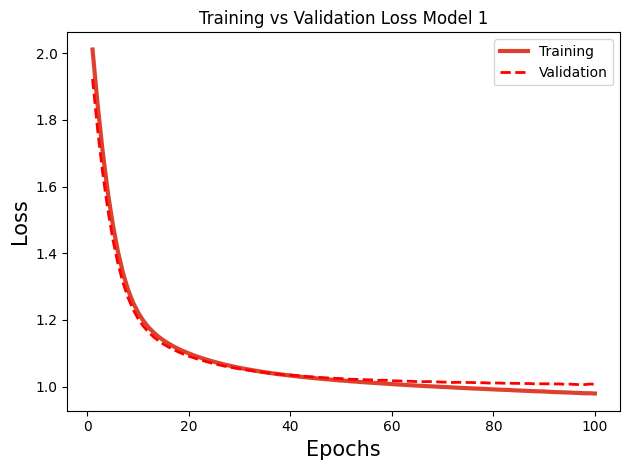

In [ ]:
X_nn_train, X_nn_valid, y_nn_train, y_nn_valid = train_test_split(
    X_train_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

''' model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(7, activation="softmax"),
]) '''

inputs = keras.Input(shape=(X_nn_train.shape[1],), name="Input")
features = layers.Dense(96, activation="relu", name="Capa3")(inputs)
features = layers.Dropout(0.5)(features)
features = layers.Dense(72, activation="relu", name="Capa3")(inputs)
outputs = layers.Dense(7, activation="softmax", name="Output")(features)
model = keras.Model(inputs=inputs, outputs=outputs, name="Modelo_Func_API")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy", # Si no 'one hoteamos' los labels (y_nn_train) hay que usar la sparse
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    X_nn_train, y_nn_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(X_nn_valid, y_nn_valid),
    verbose=0,
)

val_loss = history.history["val_loss"]
train_loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

# Train & val Loss
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.plot(range(1, epochs + 1), train_loss,
        linewidth=3,
        label='Training')
plt.plot(range(1, epochs + 1), val_loss,
        linewidth=2, linestyle='--',
        label='Validation',
         color="red")

plt.title("Training vs Validation Loss Model 1")
plt.legend(loc='upper right')
plt.tight_layout()


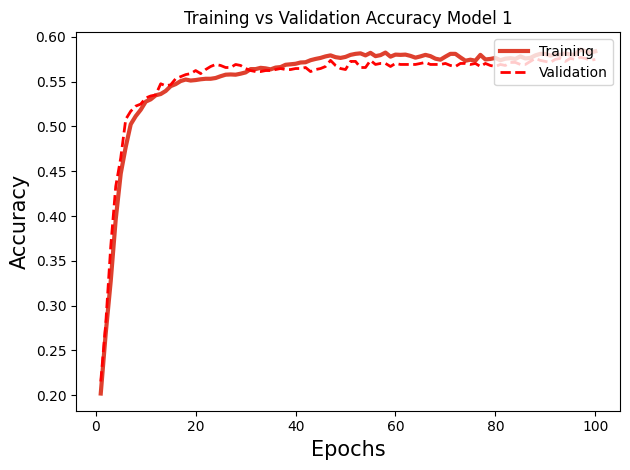

In [ ]:
# Train & val Accuracies
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.plot(range(1, epochs + 1), train_accuracy,
        linewidth=3,
        label='Training')
plt.plot(range(1, epochs + 1), val_accuracy,
        linewidth=2, linestyle='--',
        label='Validation',
         color="red")

plt.title("Training vs Validation Accuracy Model 1")
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
# Mejor accuracy
val_accuracy[-1]

0.5748299360275269